In [70]:
# https://github.com/itmo-ml-lab-ML-course/lab1-knn-YurySalyatov
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier

np.random.seed(21)

In [71]:
class ValidationError(Exception):
    pass


class KNNClassifier:
    def __init__(self, k=3, kernel=None, metric=None, fix_h=False, h=None):
        self.k = k
        self.metric = metric
        self.kernel = kernel
        self.metric = metric
        self.fix_h = fix_h
        self.h = h
        self.lowess_weights = None

    def fit(self, X_train, y_train, validation_data=None, lowess_weights=None):
        if lowess_weights is not None:
            self.lowess_weights = lowess_weights
        self.X_train = X_train
        self.y_train = y_train
        if validation_data is not None:
            self.validation_data = True
            self.valid_X, self.valid_y = validation_data
        else:
            self.validation_data = False

    def _metric(self, x1, x2):
        if self.metric:
            return self.metric(x1, x2)
        return np.sqrt(np.sum((x1 - x2) ** 2))

    def _kernel(self, u):
        if self.kernel:
            return self.kernel(u)
        return 0.5 if abs(u) < 1 else 0

    def val_loss(self, func_loss):
        if (self.validation_data):
            return func_loss(self.predict(self.valid_X), self.valid_y)
        else:
            raise ValidationError("No validation data")

    def _get_kernel_arg(self, u, xi, xk1):
        if self.fix_h and self.h:
            return self._metric(u, xi) / self.h
        if not self.fix_h:
            return self._metric(u, xi) / self._metric(u, xk1)
        return 0

    def predict(self, X_test):
        y_pred = [self._predict(x) for x in X_test]
        return np.array(y_pred)

    def _predict(self, x):
        distances = [self._metric(x, x_train) for x_train in self.X_train]
        indices = np.argsort(distances)
        k_indices = indices[:self.k]
        k1_ind = indices[self.k]
        # print(k_indices)
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        res = {}
        for y_class in set(k_nearest_labels):
            if y_class not in res:
                res[y_class] = 0
            for ind in k_indices:
                if self.y_train[ind] == y_class:
                    w = 1
                    if self.lowess_weights is not None:
                        w = self.lowess_weights[ind]
                    res[y_class] += w*self._kernel(self._get_kernel_arg(x, self.X_train[ind], self.X_train[k1_ind]))
        return max(res, key=res.get)


In [72]:
from math import exp, sqrt, pi


def uniform(u):
    return 0.5 if abs(u) < 1 else 0


def gaussian(u):
    return exp(-u ** 2 / 2) / sqrt(2 * pi)


def any_kernel(a, b, alpha, name):
    def param_kernel(u):
        return alpha * (1 - abs(u) ** a) ** b

    param_kernel.__name__ = name
    return param_kernel


triangular = any_kernel(1, 1, 1, "triangular")
epanechnikov = any_kernel(2, 1, 3 / 4, "epanechnikov")
quartic = any_kernel(2, 2, 15 / 16, "quartic")

kernels = [uniform, gaussian, triangular, epanechnikov, quartic]

In [73]:
from math import pow


def cos_distance(a, b):
    return 1 - np.sum(a * b) / (np.sqrt(np.sum(a ** 2) * np.sum(b ** 2)))


def minc_distance_p(name, p=2):
    def distance(a, b):
        return pow(np.sum(np.power(np.abs(a - b), p)), 1 / p)

    distance.__name__ = name
    return distance


def cheb_distance(a, b):
    return np.max(np.abs(a - b))


manh_distance = minc_distance_p("manh_distance", p=1)
eckl_distance = minc_distance_p("eckl_distance")

metrics = [cos_distance, cheb_distance, manh_distance, eckl_distance]

In [74]:
data, target = datasets.load_wine(return_X_y=True, as_frame=True)

In [75]:
from sklearn.preprocessing import MinMaxScaler

print(data.head())

scaler = MinMaxScaler()
data = pd.DataFrame(scaler.fit_transform(data))
print(data.head())
data = data.to_numpy()

   alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   od280/od315_of_diluted_wines  proline  
0                  

In [76]:
print(target.head())
target = target.to_numpy()
print(target[:4])

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int32
[0 0 0 0]


In [77]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [78]:
print(X_train.shape, X_test.shape, X_valid.shape)

(113, 13) (36, 13) (29, 13)


In [79]:
knn = KNNClassifier(k=3)
knn.fit(X_train, y_train, validation_data=(X_valid, y_valid))
predictions = knn.predict(X_test)
print(predictions)
print(len(predictions))

[0 0 2 0 1 0 1 2 1 2 0 2 0 2 0 1 1 1 0 1 0 1 1 2 2 2 1 0 1 0 0 1 2 0 0 0]
36


In [80]:
import optuna

from sklearn.metrics import accuracy_score


def objective(trial, kernel, metric):
    k = trial.suggest_int('k', 1, 50)

    model = KNNClassifier(k=k, kernel=kernel, metric=metric)
    model.fit(X_train, y_train, validation_data=(X_valid, y_valid))

    accuracy = model.val_loss(accuracy_score)

    return accuracy

In [81]:
best_k = {}

for kernel in kernels:
    for metric in metrics:
        study = optuna.create_study(direction='maximize')
        study.optimize(lambda trial: objective(trial, kernel, metric), n_trials=100)
        best_k[(kernel, metric)] = study.best_params["k"]


[I 2024-04-03 20:28:13,352] A new study created in memory with name: no-name-16d3c17a-fc2a-4880-94c6-009a08559650
[I 2024-04-03 20:28:13,540] Trial 0 finished with value: 0.896551724137931 and parameters: {'k': 34}. Best is trial 0 with value: 0.896551724137931.
[I 2024-04-03 20:28:13,630] Trial 1 finished with value: 0.896551724137931 and parameters: {'k': 7}. Best is trial 0 with value: 0.896551724137931.
[I 2024-04-03 20:28:13,714] Trial 2 finished with value: 0.896551724137931 and parameters: {'k': 5}. Best is trial 0 with value: 0.896551724137931.
[I 2024-04-03 20:28:13,827] Trial 3 finished with value: 0.8620689655172413 and parameters: {'k': 39}. Best is trial 0 with value: 0.896551724137931.
[I 2024-04-03 20:28:13,939] Trial 4 finished with value: 0.8275862068965517 and parameters: {'k': 46}. Best is trial 0 with value: 0.896551724137931.
[I 2024-04-03 20:28:14,014] Trial 5 finished with value: 0.896551724137931 and parameters: {'k': 4}. Best is trial 0 with value: 0.8965517241

In [82]:
for k, m in best_k:
    print(k.__name__, m.__name__, best_k[(k, m)])

uniform cos_distance 1
uniform cheb_distance 40
uniform manh_distance 11
uniform eckl_distance 6
gaussian cos_distance 1
gaussian cheb_distance 34
gaussian manh_distance 49
gaussian eckl_distance 30
triangular cos_distance 2
triangular cheb_distance 39
triangular manh_distance 44
triangular eckl_distance 28
epanechnikov cos_distance 2
epanechnikov cheb_distance 37
epanechnikov manh_distance 20
epanechnikov eckl_distance 36
quartic cos_distance 3
quartic cheb_distance 25
quartic manh_distance 49
quartic eckl_distance 28


In [83]:
for k, m in best_k:
    knn = KNNClassifier(k=best_k[(k, m)], kernel=k, metric=m)
    knn.fit(X_train, y_train, validation_data=(X_valid, y_valid))
    y_pred = knn.predict(X_test)
    print(k.__name__, m.__name__, accuracy_score(y_test, y_pred))

uniform cos_distance 0.9444444444444444
uniform cheb_distance 1.0
uniform manh_distance 0.9722222222222222
uniform eckl_distance 0.9722222222222222
gaussian cos_distance 0.9444444444444444
gaussian cheb_distance 1.0
gaussian manh_distance 0.9444444444444444
gaussian eckl_distance 0.9722222222222222
triangular cos_distance 0.9444444444444444
triangular cheb_distance 0.9722222222222222
triangular manh_distance 0.9444444444444444
triangular eckl_distance 0.9722222222222222
epanechnikov cos_distance 0.9444444444444444
epanechnikov cheb_distance 0.9722222222222222
epanechnikov manh_distance 0.9722222222222222
epanechnikov eckl_distance 0.9722222222222222
quartic cos_distance 0.9444444444444444
quartic cheb_distance 0.9722222222222222
quartic manh_distance 0.9722222222222222
quartic eckl_distance 0.9722222222222222


In [84]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
test_metric = cheb_distance
test_kernel = gaussian

def get_plots(sub_array_X=X_train, sub_array_y=y_train, my_sample=None):
    my_preds = [[], [], []]
    lib_preds = [[], [], []]
    for i in range(1, 50):
        my_knn = KNNClassifier(k = i, kernel=test_kernel, metric=test_metric)
        lib_knn = KNeighborsClassifier(n_neighbors=i)
        my_knn.fit(X_train, y_train, validation_data=(X_valid, y_valid), lowess_weights=my_sample)
        lib_knn.fit(sub_array_X, sub_array_y)
        my_pred_test = my_knn.predict(X_train)
        lib_pred_test = lib_knn.predict(X_train)
        my_preds[0].append(accuracy_score(my_pred_test, y_train))
        lib_preds[0].append(accuracy_score(lib_pred_test, y_train))
        my_pred_test = my_knn.predict(X_valid)
        lib_pred_test = lib_knn.predict(X_valid)
        my_preds[1].append(accuracy_score(my_pred_test, y_valid))
        lib_preds[1].append(accuracy_score(lib_pred_test, y_valid))
        my_pred_test = my_knn.predict(X_test)
        lib_pred_test = lib_knn.predict(X_test)
        my_preds[2].append(accuracy_score(my_pred_test, y_test))
        lib_preds[2].append(accuracy_score(lib_pred_test, y_test))
        clear_output(True)
        plt.figure(figsize=(12, 6))
        
        plt.subplot(1, 2, 1)
        plt.plot(my_preds[0], label="train")
        plt.plot(my_preds[1], label="valid")
        plt.plot(my_preds[2], label="test")
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(lib_preds[0], label="train")
        plt.plot(lib_preds[1], label="valid")
        plt.plot(lib_preds[2], label="test")
        plt.legend()
        
        plt.show()




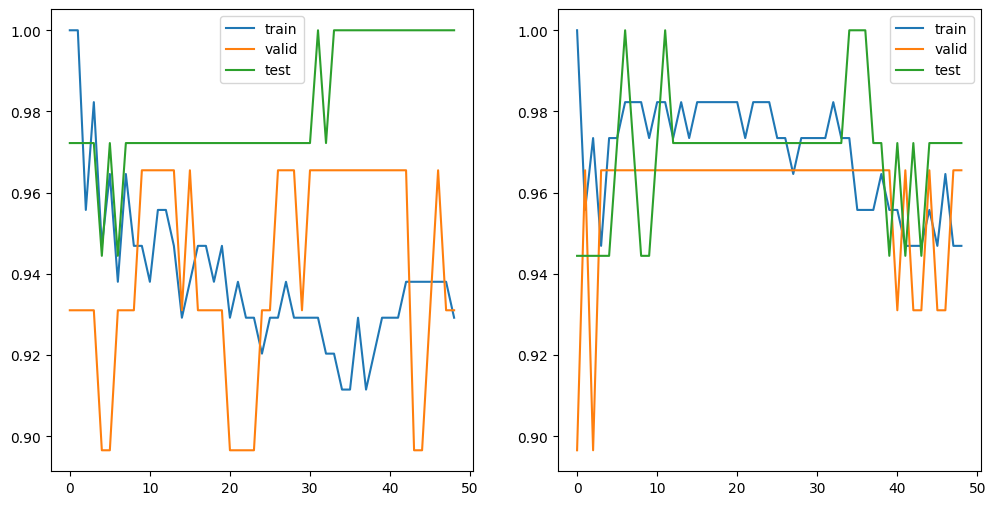

In [85]:
get_plots()

In [88]:
def sample(X_train, y_train, knn):
    ans = []
    for i in range(len(X_train)):
        removed_X = X_train[i]
        removed_y = y_train[i]
        new_X_train = np.delete(X_train, i, axis=0)
        new_y_train = np.delete(y_train, i, axis=0)
        knn.fit(new_X_train, new_y_train)
        if uniform(removed_y - knn.predict([removed_X])):
            ans.append(1)
        else:
            ans.append(0)
    return np.array(ans)
my_knn = KNNClassifier(k = best_k[(test_kernel, test_metric)], kernel=test_kernel, metric=test_metric)
my_sample = sample(X_train, y_train, my_knn)
lib_knn = KNeighborsClassifier(n_neighbors=7)
lib_sample = sample(X_train, y_train, lib_knn)

def get_sub_array(arr, ind):
    ret = []
    for i in range(len(arr)):
        if ind[i]:
            ret.append(arr[i])
    return np.array(ret)

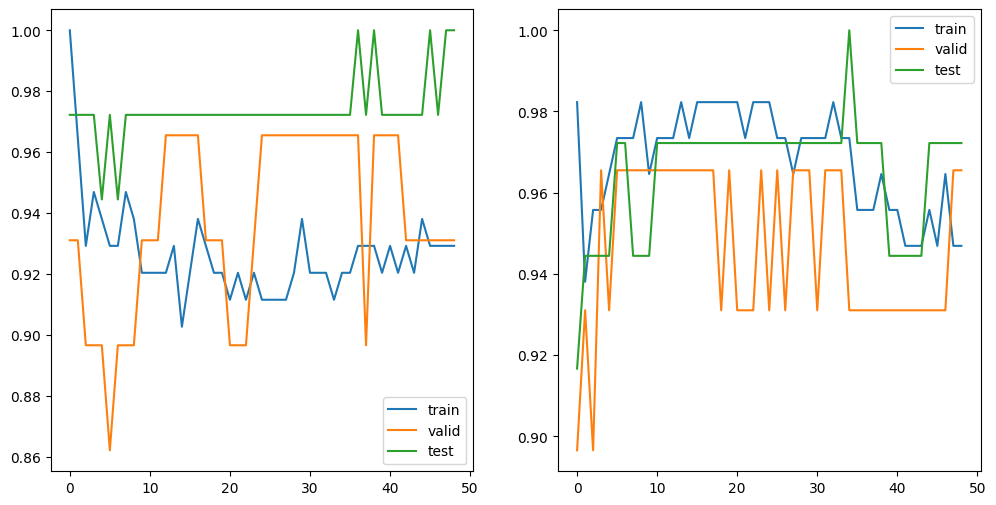

In [89]:
my_preds = [[], [], []]
lib_preds = [[], [], []]
sub_array_X = get_sub_array(X_train, lib_sample)
sub_array_y = get_sub_array(y_train, lib_sample)
get_plots(sub_array_X, sub_array_y, my_sample)